In the city of Netropolis, there are two business districts, each with four office buildings. The office buildings in each district are interconnected through a local network, forming a subnet. There is also a central data center that provides internet access, essential services, and security features like firewalls to all the office buildings. The data center is connected to each office building through dedicated network lines. 

The city council of Netropolis wants to divide the city into two zones to optimize the network infrastructure and enhance security. They want to minimize the cost of transferring data between the zones while ensuring that the firewalls and other security measures are effectively protecting the network. 

Here's the updated story with the costs and security aspects: 
- The cost of transferring data between office buildings within the same subnet (business district) is 1 unit.
- The cost of transferring data between office buildings in different subnets (business districts) is 2 units.
- The cost of transferring data between the central data center and each office building, including the firewall and other security measures, is 3 units. 

The city council wants to find the best way to divide the city into two zones to minimize the total cost of transferring data between the zones and maintain a high level of security. 

To solve this problem, the city council uses a quantum computer running the SamplingVQE algorithm. The algorithm finds the optimal division of the city into two zones, minimizing the total cost of transferring data between the zones while ensuring that the firewalls and other security measures are effectively protecting the network. 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [2]:
# Define the graph with weights  
edges = [  
    (0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 0, 1.0), # Subnet 1  
    (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0), (7, 4, 1.0), # Subnet 2  
    (8, 9, 2.0), (9, 10, 2.0), (10, 11, 2.0), (11, 8, 2.0), # connection between subnets  
    (0, 4, 3.0), (2, 6, 3.0), (8, 10, 3.0), (1, 5, 3.0), (3, 7, 3.0), 
    (9, 11, 3.0),(3, 8, 3.0),(7, 10, 3.0) # Central node connection  
]  

In [3]:
G = nx.Graph()  
G.add_weighted_edges_from(edges)
n = G.number_of_nodes()

In [4]:
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

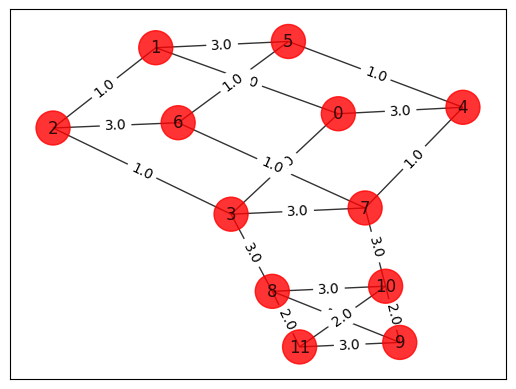

In [5]:
draw_graph(G, colors, pos)

In [6]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 0. 1. 3. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 3. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 3. 3. 0. 0. 0.]
 [3. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 3. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 3. 1. 0. 1. 0. 0. 0. 3. 0.]
 [0. 0. 0. 3. 0. 0. 0. 0. 0. 2. 3. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0. 3. 3. 2. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 3. 2. 0.]]


In [7]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 6*x_0*x_4 - 2*x_1*x_2 - 6*x_1*x_5 - 4*x_10*x_11
  - 2*x_2*x_3 - 6*x_2*x_6 - 6*x_3*x_7 - 6*x_3*x_8 - 2*x_4*x_5 - 2*x_4*x_7
  - 2*x_5*x_6 - 2*x_6*x_7 - 6*x_7*x_10 - 6*x_8*x_10 - 4*x_8*x_11 - 4*x_8*x_9
  - 4*x_9*x_10 - 6*x_9*x_11 + 5*x_0 + 5*x_1 + 10*x_10 + 7*x_11 + 5*x_2 + 8*x_3
  + 5*x_4 + 5*x_5 + 5*x_6 + 8*x_7 + 10*x_8 + 7*x_9

Subject to
  No constraints

  Binary variables (12)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9 x_10 x_11



In [8]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -20.0
Ising Hamiltonian:
0.5 * IIIIIIIIIIZZ
+ 0.5 * IIIIIIIIIZZI
+ 0.5 * IIIIIIIIZIIZ
+ 0.5 * IIIIIIIIZZII
+ 1.5 * IIIIIIIZIIIZ
+ 1.5 * IIIIIIZIIIZI
+ 0.5 * IIIIIIZZIIII
+ 1.5 * IIIIIZIIIZII
+ 0.5 * IIIIIZZIIIII
+ 1.5 * IIIIZIIIZIII
+ 0.5 * IIIIZIIZIIII
+ 0.5 * IIIIZZIIIIII
+ 1.5 * IIIZIIIIZIII
+ 1.0 * IIZZIIIIIIII
+ 1.5 * IZIIZIIIIIII
+ 1.5 * IZIZIIIIIIII
+ 1.0 * IZZIIIIIIIII
+ 1.0 * ZIIZIIIIIIII
+ 1.5 * ZIZIIIIIIIII
+ 1.0 * ZZIIIIIIIIII


In [9]:
algorithm_globals.random_seed = 123
seed = 10598

In [10]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

In [11]:
# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

In [12]:
# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

energy: -14.292808879142758
time: 95.9747908115387
max-cut objective: -34.292808879142754
solution: [0 1 0 1 1 0 1 0 0 0 1 1]
solution objective: 36.0


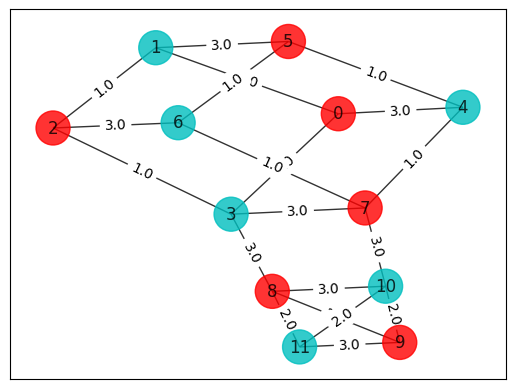

In [13]:
# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)